<a href="https://colab.research.google.com/github/kwyvanessa/Datathon_2022/blob/main/WID_Datathon_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datathon 2022

## Problem Statement

Which of the component indicators that are part of the UN composite indices (HDI, GDI, and GII) have the strongest correlation with the gender pay gap.  

# Import Data

In [34]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from google.colab import drive

## UN Human Development Reports data

[Data Dictionary](https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Composite_indices_metadata.xlsx) <br>

This dataset from the [UNHDR](https://hdr.undp.org/data-center) includes time series data for several UN HDC indices and supporting measurements in a single tabular file. The full original dataset can be downloaded from UNHDR [here](https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Composite_indices_complete_time_series.csv).   <br>

The original datset includes annual data in columnar format.  We used Tableau Prep to quickly transform the annual data into a row format, with one row for each Country/Year combination, and a single column for each variable.

Data Dictionary <br>
country: Country that data relates to <br>
year: Year of measurment <br>
region: Developing region: (AS: Arab States (20); EAP: East Asia and Pacific (26); ECA: Europe and Central Asia (17); LAC: Latin America and Caribbean (33); SA: South Asia (9); SSA: Sub Saharan Africa) <br>

Composite Indices: <br>
hdi: Human Development Index<br>
gdi:  Gender Development Index<br>
gii: Gender inequality index<br>
ihdi: Inequality-adjusted HDI<br>

Raw indicators included in composite indices:<br>
le: life expectancy<br>
gnipc: Gross National Income per capita<br>
mys: Mean years of schooling<br>
eys: Expected Years of Schooling<br>
mmr: Material mortality rate<br>
abr: Adolescent birth rate <br>
se: population with atleast some secondary ed<br>
pr: share of seats in parliament<br>
lfpr: labor force participation rate<br>
co2_prod: Co2 emissions per capita<br>
coef_inc: Coefficient of inequality<br>
ineq_le: Inequality in life expectancy<br>
ineq_inc: Inequality in income


In [35]:
# Use curl to retrieve transformed csv file from github repo and save in Colab working director
!curl -O "https://raw.githubusercontent.com/kwyvanessa/Datathon_2022/main/hdrDF_by_year_data.csv"

# Read in the csv from the Colab working directory - using a subset of the columns, and parse_dates are enabled to format of the datetime strings. I
hdrDF_y = pd.read_csv("/content/hdrDF_by_year_data.csv",\
                      usecols = ['iso3','country','region', 'hdicode','Year','hdi','le','mys', 'eys','gnipc','gdi','ihdi','coef ineq','ineq le', 'ineq inc', 'gii','mmr','abr','pr f','lfpr f', 'lfpr m', 'se f', 'se m'],\
                      infer_datetime_format= True)
# Rename columns for consistency of style
hdrDF_y.rename({'coef ineq':'coef_ineq','se m':'se_m','se f':'se_f','pr f':'pr_f','ineq le':'ineq_le','ineq inc':'ineq_inc', 'Year':'date', 'lfpr m': 'lfpr_m', 'lfpr f': 'lfpr_f'}, axis =1, inplace = True)

hdrDF_y['date'] = pd.to_datetime(hdrDF_y['date'], infer_datetime_format = True ) # convert the date column to datetime format 
hdrDF_y['year'] = hdrDF_y['date'].dt.year # create a new column for the year of the observation
hdrDF_y.sample(10)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2023k  100 2023k    0     0  17.3M      0 --:--:-- --:--:-- --:--:-- 17.3M


,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year
1389,SOM,NaN,AS,2010-01-01,Somalia,NaN,NaN,NaN,NaN,6.776557,...,50.5630,48.616425,NaN,NaN,1046.883350,NaN,NaN,NaN,130.861,2010
1798,IDN,High,EAP,2016-01-01,Indonesia,0.699,16.245752,47.782440,40.230549,17.117117,...,69.7976,15.327211,17.25630,0.585,10197.401120,0.469,0.933,13.356510,36.615,2016
198,AUT,Very High,NaN,2012-01-01,Austria,0.906,7.513977,98.855199,93.186030,28.688525,...,80.8410,3.552271,15.49980,0.836,52887.194300,0.098,0.955,16.085060,9.054,2012
242,THA,Very High,EAP,2008-01-01,Thailand,0.727,NaN,38.625286,32.638015,12.698413,...,75.4916,NaN,NaN,NaN,13123.799940,0.387,0.988,13.230310,51.162,2008
152,BLZ,Medium,LAC,1991-01-01,Belize,0.600,NaN,22.400450,21.160271,10.810811,...,70.2484,NaN,NaN,NaN,5186.014425,0.555,0.887,10.121030,123.933,1991
1956,BDI,Low,SSA,2011-01-01,Burundi,0.410,29.488159,10.107240,6.662135,34.931507,...,57.7692,34.250526,13.24395,0.285,846.029433,0.537,0.910,10.538275,73.442,2011
3117,NOR,Very High,NaN,1994-01-01,Norway,0.873,NaN,79.492737,72.728980,36.363636,...,77.7726,NaN,NaN,NaN,39504.124940,0.118,0.976,16.110979,14.856,1994
115,BEL,Very High,NaN,1994-01-01,Belgium,0.858,NaN,70.439577,63.024280,15.837104,...,76.7142,NaN,NaN,NaN,39684.170440,0.162,0.966,16.851589,10.441,1994
3259,NOR,Very High,NaN,2007-01-01,Norway,0.938,NaN,99.846321,99.780830,36.094675,...,80.5033,NaN,NaN,NaN,67351.252370,0.079,0.991,17.562300,8.772,2007
4361,LBY,High,AS,2017-01-01,Libya,0.714,NaN,44.960000,69.360000,15.957447,...,72.4818,9.205768,NaN,NaN,13686.022530,0.264,0.973,12.789937,7.347,2017


In [36]:
# Drop rows that have an iso value that begins with 'ZZ'
hdrDF_y.drop(labels = hdrDF_y.loc[hdrDF_y['iso3'].str.contains('ZZ') == True], axis = 0, errors='ignore', inplace = True)       
hdrDF_y

,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year
0,DJI,Low,AS,2009-01-01,Djibouti,0.445,NaN,NaN,NaN,13.846154,...,59.6727,NaN,NaN,NaN,2803.308019,NaN,NaN,5.583350,24.647,2009
1,BLZ,Medium,LAC,2001-01-01,Belize,0.643,NaN,54.882461,54.105932,13.513514,...,68.3572,NaN,NaN,NaN,6175.395903,0.509,0.924,11.864430,99.264,2001
2,SVN,Very High,NaN,2015-01-01,Slovenia,0.903,5.297673,98.930481,97.439178,27.692308,...,80.8218,2.487548,11.17606,0.854,32738.328430,0.063,1.003,17.291990,4.679,2015
3,MLT,Very High,NaN,2005-01-01,Malta,0.832,NaN,67.836281,58.782822,9.230769,...,79.6465,NaN,NaN,NaN,28205.895980,0.285,0.923,14.814800,20.183,2005
4,ROU,Very High,NaN,1994-01-01,Romania,0.682,NaN,78.510602,65.954482,5.555556,...,69.5789,NaN,NaN,NaN,11361.396570,0.482,0.957,10.283660,46.290,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,PAK,Low,SA,2006-01-01,Pakistan,0.493,NaN,44.042240,19.914881,20.361991,...,63.7312,NaN,NaN,NaN,3761.372437,0.614,0.694,6.281110,60.166,2006
6588,COL,High,LAC,1991-01-01,Colombia,0.619,NaN,42.369342,42.013230,9.811321,...,68.8127,NaN,NaN,NaN,7978.104071,0.531,0.955,9.490810,96.557,1991
6589,GRD,High,LAC,1997-01-01,Grenada,NaN,NaN,NaN,NaN,NaN,...,72.5677,NaN,NaN,NaN,8826.030278,NaN,NaN,15.529503,63.858,1997
6590,FRA,Very High,NaN,1994-01-01,France,0.823,NaN,59.911082,51.941091,9.020045,...,77.7678,NaN,NaN,NaN,34801.772780,0.202,0.982,15.589100,10.020,1994


## UN Women Data Hub Wage Data

Data on Average Hourly Wage by gender, country and year was sourced from the [UN Women SDG Indicators Dashboard](https://data.unwomen.org/data-portal).<br>
The Average Hourly Wage data is averaged for all occupations.<br>
This dataset will be used to calculate a 'Wage Ratio' to estimate the target variable of the gender pay gap.  The Wage Ratio is calculated below as the Average Hourly Wage (Female) divided by the Average Hourly Wage (Male). 

In [37]:
# Use curl to get csv file from github repo and save in Colab working directory
!curl -O "https://raw.githubusercontent.com/kwyvanessa/Datathon_2022/main/UNWDH_wages_all.csv"
# Read in the csv from the working directory  - using a subset of the columns.
wages = pd.read_csv("/content/UNWDH_wages_all.csv", usecols = ['REF_AREA Description','TIME_PERIOD','OBS_VALUE','Sex'])
#rename columns
wages.rename({'REF_AREA Description': 'Country', 'TIME_PERIOD': 'Year', 'OBS_VALUE': 'avgHrlyWage'},axis=1, inplace = True) 
#Filter the data
wages = wages.loc[wages['Sex'].isin(['Female','Male'])]
wages.sample(10)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  629k  100  629k    0     0  6698k      0 --:--:-- --:--:-- --:--:-- 6628k


,Country,Year,avgHrlyWage,Sex
762,Argentina,2018,129.0,Male
1247,Honduras,2002,19.2,Male
1203,Guatemala,2002,9.4,Male
1206,Guatemala,2003,10.1,Male
1200,Guatemala,2000,8.5,Male
1333,Israel,2014,58.0,Male
1293,Honduras,2018,42.9,Female
526,Myanmar,2019,1188.0,Male
805,Belgium,2016,17.7,Female
755,Argentina,2013,34.0,Female


In [38]:
#Pivot the data
wages_wide_mi = wages.pivot(index = ['Country', 'Year'], columns = 'Sex', values = ['avgHrlyWage'])
#drop the multilevel column index
wages_wide_mi.columns = wages_wide_mi.columns.droplevel(0)
#remove the multilevel index
wages_wide = wages_wide_mi.reset_index()
wages_wide.sample(10)

Sex,Country,Year,Female,Male
148,Ecuador,2003,1.5,1.6
290,Mauritius,2015,106.9,127.9
206,Guatemala,2004,8.7,9.6
428,Switzerland,2018,37.0,45.0
263,Latvia,2018,6.0,7.0
360,Peru,2012,5.6,7.5
41,Bolivia (Plurinational State of),2007,7.8,8.2
64,Brazil,2001,3.3,4.0
62,Bosnia and Herzegovina,2019,4.2,4.8
219,Honduras,2002,19.8,19.2


In [39]:
# Add a new calculated field for the ratio of Female wages in a given year and country as a percentage of Male wages
wages_wide['wage_ratio'] = wages_wide['Female'] / wages_wide['Male']
wages_wide.sample(10)

Sex,Country,Year,Female,Male,wage_ratio
285,Malta,2018,11.0,13.0,0.846154
478,Viet Nam,2016,26309.3,27680.6,0.950460
384,Republic of Korea,2017,14890.0,22246.0,0.669334
189,Finland,2013,17.6,21.3,0.826291
218,Honduras,2001,19.7,20.7,0.951691
407,South Africa,2019,19.0,21.0,0.904762
329,Paraguay,2001,4922.9,5409.1,0.910114
129,Czechia,2017,157.5,196.9,0.799898
75,Brazil,2013,8.5,9.8,0.867347
26,Bangladesh,2017,62.6,58.5,1.070085


In [40]:
# Drop unneeded columns, rename columns
wages_wide.drop(['Female','Male'], axis =1, inplace = True, errors = 'ignore')
wages_wide.rename({'Country':'country','Year':'year'}, axis = 1, inplace = True)
wages_wide.sample(10)

Sex,country,year,wage_ratio
297,Mexico,2008,0.866097
170,El Salvador,2005,0.937500
158,Ecuador,2013,1.080000
247,Ireland,2018,0.916667
25,Austria,2018,0.800000
387,Romania,2014,0.952756
437,Uganda,2017,0.668676
251,Israel,2018,0.840121
226,Honduras,2009,1.107817
260,Lao People's Democratic Republic,2017,1.106931


## Merge Dataframes
Combine the UNHDR data with the UN Wage Data to produce a single dataframe for analysis<br>

In [41]:
# Compare country column from each dataframe
print(f"wages: {wages_wide['country'].nunique()}")
print(f"hdrDF {hdrDF_y['country'].nunique()}")

wages: 102
hdrDF 206


In [42]:
# Rename country values to make consistent between the two datasets
wages_wide.loc[wages_wide['country'] == 'Republic of Korea','country'] = 'Korea (Republic of)' # Korea
wages_wide.loc[wages_wide['country'] == 'United Kingdom of Great Britain and Northern Ireland', 'country'] = 'United Kingdom' # United Kingdom
hdrDF_y.loc[hdrDF_y['country'] == 'Eswatini (Kingdom of)', 'country'] = 'Eswatini' #Eswatini

In [43]:
wages_wide.loc[wages_wide['country'] == 'United Kingdom']

Sex,country,year,wage_ratio
439,United Kingdom,2014,0.792899
440,United Kingdom,2015,0.795181
441,United Kingdom,2016,0.801170
442,United Kingdom,2017,0.801136
443,United Kingdom,2018,0.802198
444,United Kingdom,2019,0.808511


In [44]:
# Merge datasets
paygap = pd.merge(hdrDF_y, wages_wide, how = 'inner', on = ['country','year'])
paygap.sample(10)

,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
334,VEN,Medium,LAC,2001-01-01,Venezuela (Bolivarian Republic of),0.689,NaN,37.835458,40.124124,9.696970,...,NaN,NaN,NaN,16343.749000,0.527,0.982,11.189965,93.875,2001,0.976101
36,SWE,Very High,NaN,2018-01-01,Sweden,0.942,6.332110,91.777027,91.309296,46.131805,...,2.728509,12.581130,0.882,53050.916380,0.031,0.985,19.691019,4.066,2018,0.893025
51,ECU,High,LAC,2011-01-01,Ecuador,0.743,19.974463,45.870152,44.861488,32.258065,...,11.902270,31.638398,0.591,10814.255400,0.431,0.964,14.863977,91.278,2011,0.875000
129,PAK,Low,SA,2016-01-01,Pakistan,0.541,28.636338,47.255161,26.970261,20.045045,...,29.925085,11.584400,0.379,4337.277938,0.545,0.775,7.989450,46.735,2016,0.891892
291,LTU,Very High,NaN,2014-01-01,Lithuania,0.861,10.016580,95.615608,91.054337,24.113475,...,4.937850,19.728880,0.772,28610.728710,0.135,1.023,16.462509,14.045,2014,0.880952
124,UGA,Low,SSA,2017-01-01,Uganda,0.520,25.275483,36.160000,28.020000,34.298441,...,22.971682,24.940388,0.388,2025.816431,0.534,0.888,10.401666,114.781,2017,0.668676
122,GRC,Very High,NaN,2014-01-01,Greece,0.879,12.832534,71.673607,63.682461,21.000000,...,3.642162,20.690590,0.764,27850.416130,0.118,0.968,17.898500,7.903,2014,0.871287
445,CZE,Very High,NaN,2012-01-01,Czechia,0.874,5.254216,99.752907,99.876343,20.640569,...,3.393329,10.978870,0.827,30967.187550,0.142,0.979,16.075911,12.554,2012,0.787183
277,AUT,Very High,NaN,2018-01-01,Austria,0.917,6.480915,100.000000,100.000000,34.836066,...,3.131075,13.394220,0.856,54587.744450,0.061,0.966,16.066750,5.855,2018,0.800000
328,SLV,Medium,LAC,2018-01-01,El Salvador,0.680,19.024304,48.602671,41.468346,30.952381,...,10.847123,22.431980,0.549,8136.126957,0.370,0.981,12.714490,58.197,2018,1.000000


# Exploratory Data Analysis

## Shapes, Sizes, and Info

In [46]:
# convert indices from object type to float64
paygap[['hdi','coef_ineq','se_m','se_f','pr_f','mys','eys','mmr','lfpr_m','lfpr_f','le','ineq_le','ineq_inc','ihdi','gnipc','gii','gdi','abr','wage_ratio']] \
  = paygap[['hdi','coef_ineq','se_m','se_f','pr_f','mys','eys','mmr','lfpr_m','lfpr_f','le','ineq_le','ineq_inc','ihdi','gnipc','gii','gdi','abr','wage_ratio']].astype(np.float64)

# Convert date to datetime format
paygap['date'] = pd.to_datetime(paygap['date'], infer_datetime_format = True )

In [47]:
# rows and columns of dataframe
paygap_sh = paygap.shape    # number of instances (rows) and features (cols)
paygap_sz = paygap.size     # the number of elements
paygap_col = paygap.columns # to know just the names of the columns or features

print(f"paygap dataframe: \n\n\
 shape (rows|cols): {paygap_sh}\n \
size: {paygap_sz}\n\n \
Features|Columns\n{paygap_col}")

paygap dataframe: 

 shape (rows|cols): (484, 25)
 size: 12100

 Features|Columns
Index(['iso3', 'hdicode', 'region', 'date', 'country', 'hdi', 'coef_ineq',
       'se_m', 'se_f', 'pr_f', 'mys', 'mmr', 'lfpr_m', 'lfpr_f', 'le',
       'ineq_le', 'ineq_inc', 'ihdi', 'gnipc', 'gii', 'gdi', 'eys', 'abr',
       'year', 'wage_ratio'],
      dtype='object')


In [48]:
# Displays the concise summary of dataframe
paygap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   iso3        484 non-null    object        
 1   hdicode     484 non-null    object        
 2   region      355 non-null    object        
 3   date        484 non-null    datetime64[ns]
 4   country     484 non-null    object        
 5   hdi         484 non-null    float64       
 6   coef_ineq   320 non-null    float64       
 7   se_m        484 non-null    float64       
 8   se_f        484 non-null    float64       
 9   pr_f        483 non-null    float64       
 10  mys         484 non-null    float64       
 11  mmr         484 non-null    float64       
 12  lfpr_m      484 non-null    float64       
 13  lfpr_f      484 non-null    float64       
 14  le          484 non-null    float64       
 15  ineq_le     353 non-null    float64       
 16  ineq_inc    329 non-null  

## Total count of null values for all the attributes

In [49]:
print("Columns with missing values: ")
print(paygap.columns[paygap.isnull().any()].tolist())

Columns with missing values: 
['region', 'coef_ineq', 'pr_f', 'ineq_le', 'ineq_inc', 'ihdi', 'gii', 'gdi']


In [50]:
# to know just the missing values
print(paygap.isnull().sum())

iso3            0
hdicode         0
region        129
date            0
country         0
hdi             0
coef_ineq     164
se_m            0
se_f            0
pr_f            1
mys             0
mmr             0
lfpr_m          0
lfpr_f          0
le              0
ineq_le       131
ineq_inc      155
ihdi          164
gnipc           0
gii             1
gdi            11
eys             0
abr             0
year            0
wage_ratio      0
dtype: int64


In [51]:
print(paygap.columns[paygap.notnull().any()].tolist())

['iso3', 'hdicode', 'region', 'date', 'country', 'hdi', 'coef_ineq', 'se_m', 'se_f', 'pr_f', 'mys', 'mmr', 'lfpr_m', 'lfpr_f', 'le', 'ineq_le', 'ineq_inc', 'ihdi', 'gnipc', 'gii', 'gdi', 'eys', 'abr', 'year', 'wage_ratio']


In [52]:
# to know just the non null values
total_nn = paygap.count() - paygap.isnull().sum()
print(total_nn)

iso3          484
hdicode       484
region        226
date          484
country       484
hdi           484
coef_ineq     156
se_m          484
se_f          484
pr_f          482
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
ineq_le       222
ineq_inc      174
ihdi          156
gnipc         484
gii           482
gdi           462
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64


##Summary statistics 

In [53]:
# Summary statistics of the categorical values
paygap.describe(include ='object')

,iso3,hdicode,region,country
count,484,484,355,484
unique,101,4,6,101
top,URY,Very High,LAC,Uruguay
freq,20,222,248,20


In [54]:
#Summary stats of the numerical values
paygap.describe()

,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
count,484.000000,320.000000,484.000000,484.000000,483.000000,484.000000,484.000000,484.000000,484.000000,484.000000,353.000000,329.000000,320.000000,484.000000,483.000000,473.000000,484.000000,484.000000,484.000000,484.000000
mean,0.756374,15.751772,62.626759,58.968734,21.947963,8.912998,72.857438,73.748864,50.898961,74.714343,9.597311,23.396456,0.663547,19565.045418,0.336164,0.965484,14.168609,50.963091,2012.078512,0.911711
std,0.111822,7.507242,23.216009,23.738953,10.954223,2.524276,102.374310,7.721715,9.859812,5.342976,7.335194,9.163534,0.149649,15383.349935,0.166678,0.038379,2.442181,35.019398,5.330295,0.117139
min,0.398000,4.361375,13.447695,7.278934,4.081633,1.722000,2.000000,51.253000,13.996000,52.825300,2.241741,8.524723,0.248000,1386.630627,0.018000,0.754000,7.372990,2.363000,2000.000000,0.578431
25%,0.684000,9.271215,44.899324,41.287659,13.171933,7.170078,11.000000,68.106750,45.204250,71.925975,3.775587,16.690000,0.564500,7958.615829,0.162500,0.949000,12.586044,13.432750,2009.000000,0.839394
50%,0.761500,15.010375,58.891867,55.858055,19.230769,8.673390,46.500000,74.192500,50.828000,74.868050,6.918000,21.434030,0.669000,14331.322935,0.376000,0.973000,14.125945,61.920500,2014.000000,0.904304
75%,0.840250,21.385310,83.517539,77.923035,29.249531,10.878768,92.000000,79.775000,55.683000,78.602600,12.369620,30.297652,0.792500,25942.054245,0.470500,0.989000,16.069040,76.775000,2017.000000,0.979824
max,0.962000,37.399747,100.000000,100.000000,55.660377,14.037120,1140.000000,89.522000,83.876000,83.655700,40.849140,56.996000,0.913000,83495.108300,0.690000,1.036000,19.762920,167.138000,2019.000000,1.409669


In [55]:
# For the dataframe group numeric features by each categorical feature 
# Displays categorical features noted above that have unique (2nd row) features < 100
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        display(paygap.groupby(column).mean())
     

,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
hdicode,,,,,,,,,,,,,,,,,,,,
High,0.723912,17.908825,59.984475,56.497046,18.685543,8.360739,72.229730,75.310020,50.200764,73.681330,10.933429,27.460042,0.605843,11276.968493,0.405973,0.966165,13.424621,60.760541,2011.560811,0.914677
Low,0.492438,30.039715,30.316660,16.851426,20.451785,4.090415,415.187500,74.203063,54.981250,61.117956,30.130393,22.867904,0.345429,2409.031816,0.578688,0.838800,9.812705,95.184875,2014.375000,0.767170
Medium,0.632194,25.182766,39.987992,34.636422,19.905627,6.307742,138.204082,79.836806,49.824592,69.263367,17.395838,31.950787,0.476000,6882.107231,0.488347,0.947299,11.779863,82.223724,2010.387755,0.994252
Very High,0.851856,10.492797,76.710628,74.393298,25.146724,10.778812,19.756757,69.987887,51.544477,78.789225,4.871272,18.856215,0.778934,31925.673998,0.204371,0.981563,16.033031,27.444563,2013.004505,0.883713


,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
region,,,,,,,,,,,,,,,,,,,,
AS,0.728250,14.450390,76.789690,71.656644,12.710337,9.931514,41.750000,64.106250,16.954500,76.639000,8.905803,17.911850,0.617667,11092.861615,0.443500,0.892750,10.601525,25.682250,2018.250000,1.162408
EAP,0.707364,19.610009,64.753719,58.625768,18.583996,8.409085,86.000000,76.074848,57.641000,72.244491,13.145941,20.482429,0.539687,14280.462148,0.353344,0.974182,12.891680,30.520121,2015.121212,0.958289
ECA,0.777536,11.853381,88.773263,78.366272,22.545206,10.232040,14.392857,61.117107,41.374429,76.081204,5.616375,19.283906,0.685148,14127.679880,0.195857,0.960214,14.086391,16.359143,2015.642857,0.888236
LAC,0.710274,20.509616,48.079033,46.190863,20.417169,7.627976,84.495968,78.409073,49.983004,73.139718,12.130061,32.259984,0.580385,11923.823217,0.440500,0.967443,13.351115,76.664077,2009.310484,0.955782
SA,0.681667,21.973183,60.791842,54.957743,12.467981,7.999033,87.750000,76.063500,36.104500,72.460725,13.997224,18.995821,0.513889,8986.628260,0.440417,0.902167,12.059022,33.406750,2016.166667,0.898631
SSA,0.616500,26.060039,48.669509,37.815254,20.019413,6.664392,297.233333,72.976733,56.973800,65.405130,22.303914,26.950491,0.457769,9315.559775,0.500267,0.915733,12.285127,78.532000,2015.333333,0.805992


## Visualizing the missing values

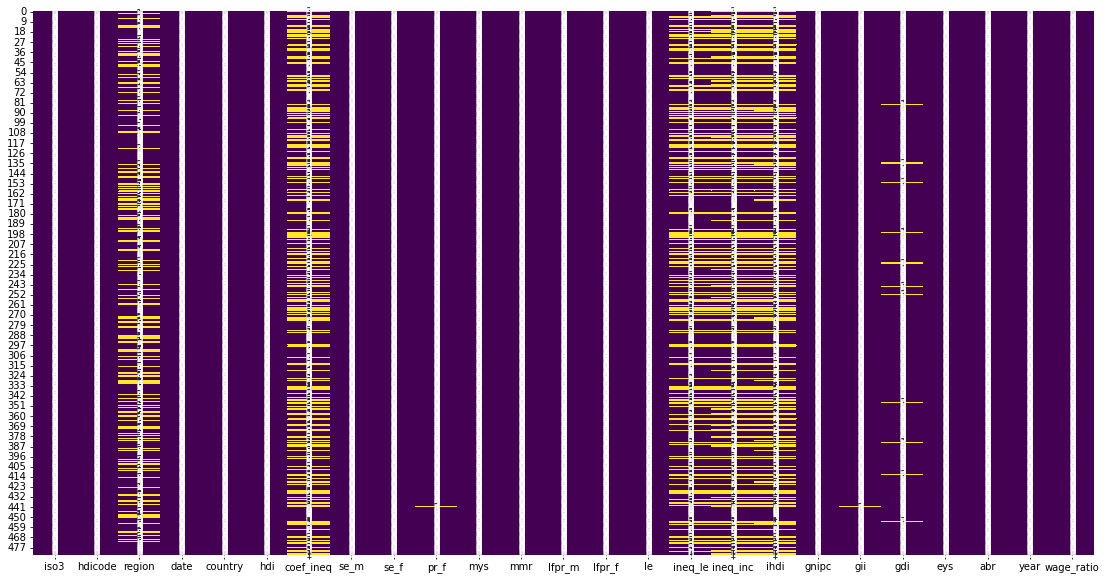

In [56]:
plt.figure(figsize=(19, 10))

# setting the parameter values
sns.heatmap(paygap.isnull(),cbar=False,cmap='viridis', annot = True)

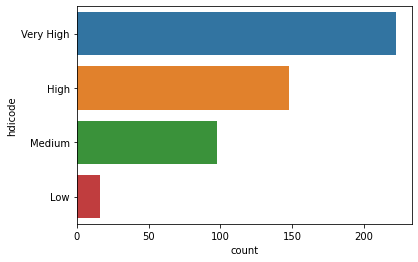

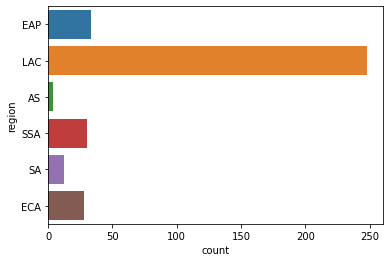

In [57]:
# Plot of each categorical features < 100
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        sns.countplot(y=column, data=paygap)
        plt.show()

# Data Preparation

## Drop selected variables

In [58]:
# Drop selected variables 
paygap.drop(["coef_ineq","ineq_le","ineq_inc","ihdi","iso3","gdi", "gii", "hdi", "hdicode"], axis=1, inplace=True)
paygap.columns

Index(['region', 'date', 'country', 'se_m', 'se_f', 'pr_f', 'mys', 'mmr',
       'lfpr_m', 'lfpr_f', 'le', 'gnipc', 'eys', 'abr', 'year', 'wage_ratio'],
      dtype='object')

In [59]:
# Fill in missing regions 
region_uniq = paygap["region"].sort_values().unique()
print(f"paygap region : {region_uniq}")

paygap["region"].fillna("No Region", inplace = True)
paygap["region"].sort_values().unique()

paygap region : ['AS' 'EAP' 'ECA' 'LAC' 'SA' 'SSA' nan]


array(['AS', 'EAP', 'ECA', 'LAC', 'No Region', 'SA', 'SSA'], dtype=object)

In [60]:
# Fill in the missing remaining values
paygap["pr_f"].fillna(0, inplace = True)

In [61]:
# to know just the missing values
print(paygap.isnull().sum())

region        0
date          0
country       0
se_m          0
se_f          0
pr_f          0
mys           0
mmr           0
lfpr_m        0
lfpr_f        0
le            0
gnipc         0
eys           0
abr           0
year          0
wage_ratio    0
dtype: int64


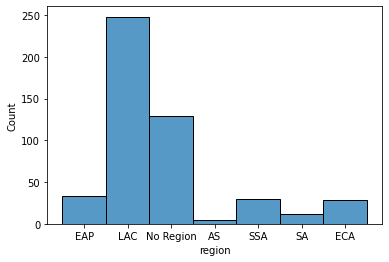

In [62]:
# based on version that replaces null values with 0
# histograms of variable distribution
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        sns.histplot(data = paygap[column])
        plt.show()


The year with the most complete data is: 2014


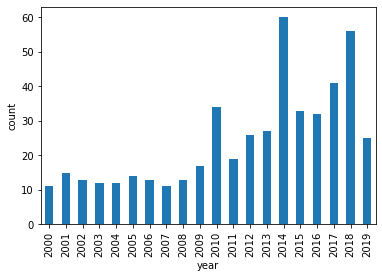

In [63]:
# determine year with the most complete data
count = paygap.groupby(by='year')['wage_ratio'].count()
count.plot.bar()
plt.ylabel('count')
print('The year with the most complete data is:',count.idxmax())

In [64]:
# check for duplicates
print('before dropping duplicates:', paygap.count())

# after dropping duplicates
paygap.drop_duplicates()
print('after dropping duplicates:', paygap.count())

before dropping duplicates: region        484
date          484
country       484
se_m          484
se_f          484
pr_f          484
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
gnipc         484
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64
after dropping duplicates: region        484
date          484
country       484
se_m          484
se_f          484
pr_f          484
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
gnipc         484
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64


## Encoding categorical variables

In [65]:
# Make a copy of dataframe for additional transformation
paygap_enc = paygap.copy()

# one-hot encoding of categorical data to integer values except for country
paygap_enc = pd.get_dummies(paygap_enc, columns = ['region'])
paygap_enc.dtypes

date                datetime64[ns]
country                     object
se_m                       float64
se_f                       float64
pr_f                       float64
mys                        float64
mmr                        float64
lfpr_m                     float64
lfpr_f                     float64
le                         float64
gnipc                      float64
eys                        float64
abr                        float64
year                         int64
wage_ratio                 float64
region_AS                    uint8
region_EAP                   uint8
region_ECA                   uint8
region_LAC                   uint8
region_No Region             uint8
region_SA                    uint8
region_SSA                   uint8
dtype: object

In [66]:
paygap_enc.sample(10)

,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,...,abr,year,wage_ratio,region_AS,region_EAP,region_ECA,region_LAC,region_No Region,region_SA,region_SSA
143,2014-01-01,Portugal,52.223122,50.775169,31.304348,8.870940,8.0,64.511,53.812,81.2157,...,9.063,2014,0.851852,0,0,0,0,1,0,0
374,2011-01-01,Paraguay,41.107250,37.772877,13.600000,7.508543,103.0,81.128,54.303,72.1314,...,76.450,2011,0.942017,0,0,0,1,0,0,0
354,2014-01-01,Malaysia,74.506401,69.825391,14.234875,10.143660,30.0,77.617,50.128,75.1459,...,13.434,2014,1.017857,0,1,0,0,0,0,0
185,2017-01-01,Spain,79.343666,74.340221,38.636364,10.076715,4.0,63.891,52.631,83.0295,...,6.932,2017,0.875000,0,0,0,0,1,0,0
76,2016-01-01,Bolivia (Plurinational State of),63.317875,53.559769,51.807229,9.162833,161.0,77.808,56.972,67.6277,...,68.823,2016,0.898990,0,0,0,1,0,0,0
193,2014-01-01,Romania,92.243301,86.119278,11.663808,10.859340,21.0,64.212,46.190,74.9279,...,36.568,2014,0.952756,0,0,0,0,1,0,0
302,2014-01-01,Spain,76.712570,70.892616,37.012987,9.720040,4.0,65.047,53.115,82.8580,...,8.073,2014,0.875000,0,0,0,0,1,0,0
137,2005-01-01,Colombia,40.741482,41.212292,10.861423,7.284200,83.0,80.438,51.340,73.0814,...,85.791,2005,1.023810,0,0,0,1,0,0,0
301,2018-01-01,Netherlands,91.772148,89.016960,35.555556,12.323010,5.0,69.583,59.086,81.7741,...,2.611,2018,0.850000,0,0,0,0,1,0,0
249,2019-01-01,Paraguay,54.199551,51.103642,16.800000,8.810710,84.0,84.348,60.085,73.6207,...,72.448,2019,1.070971,0,0,0,1,0,0,0


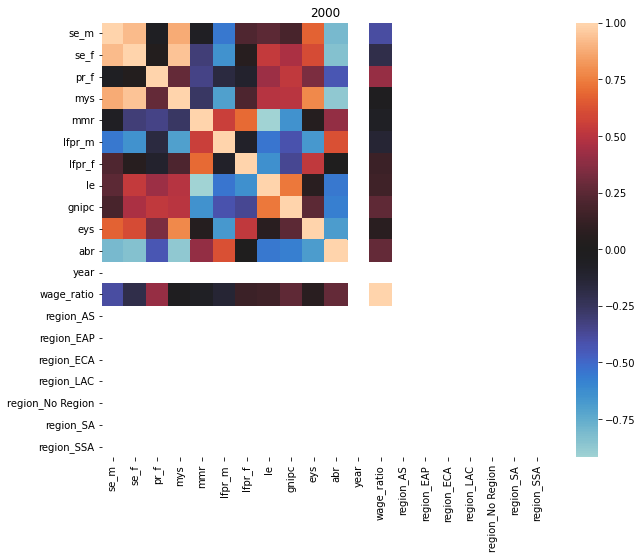

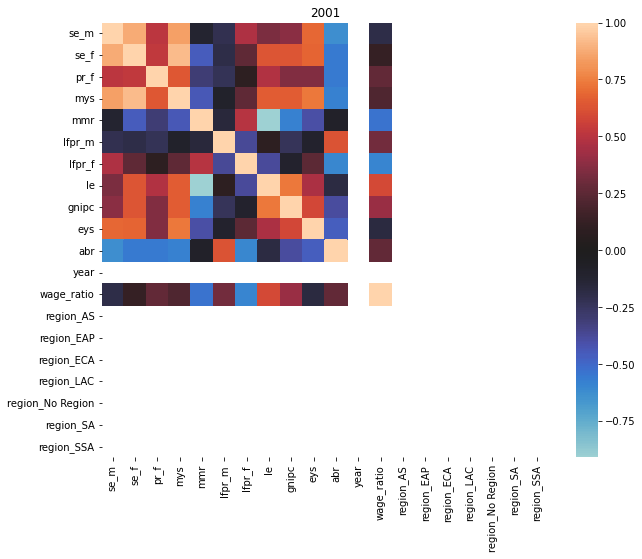

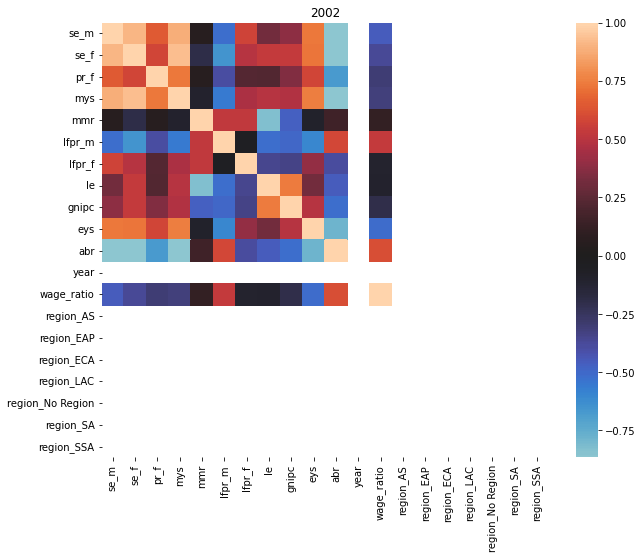

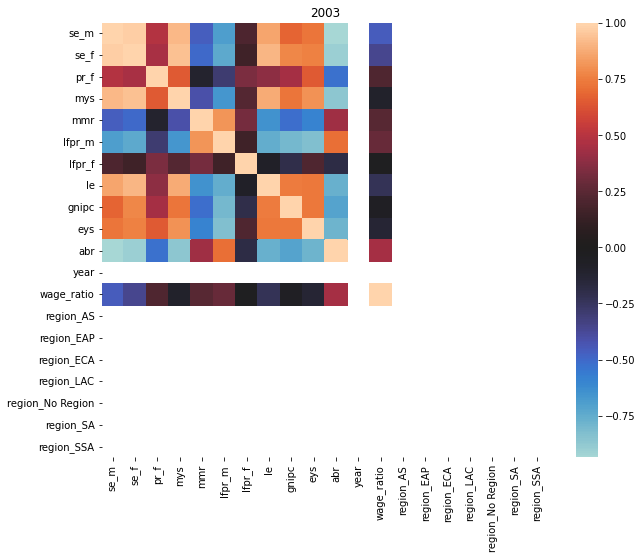

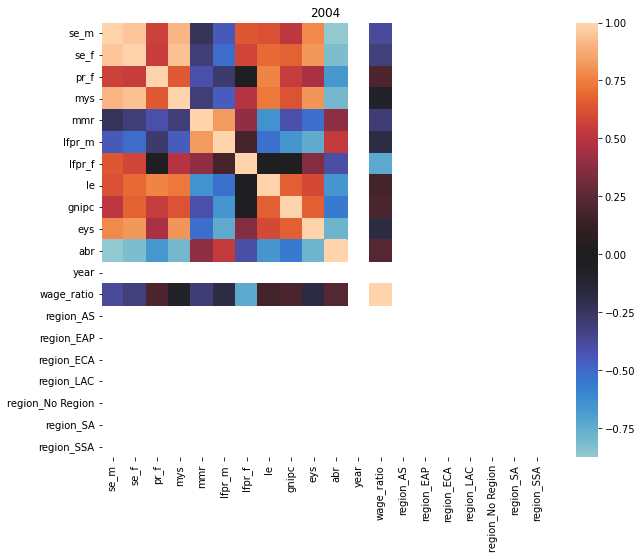

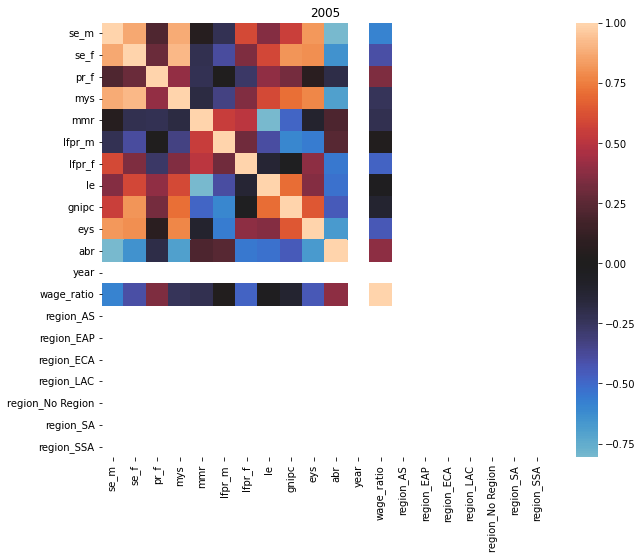

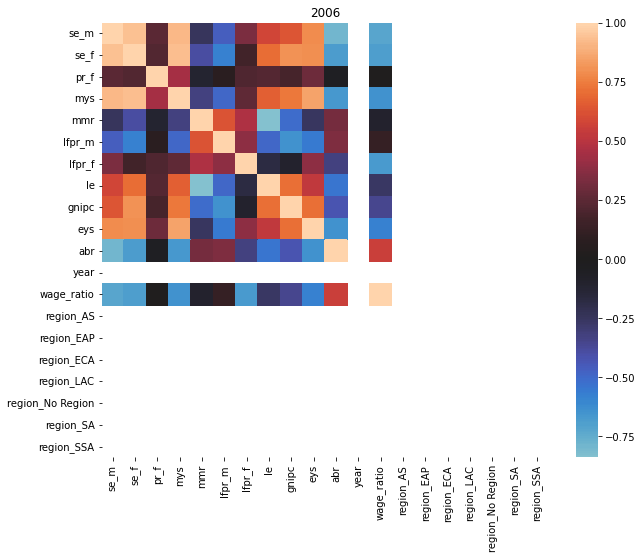

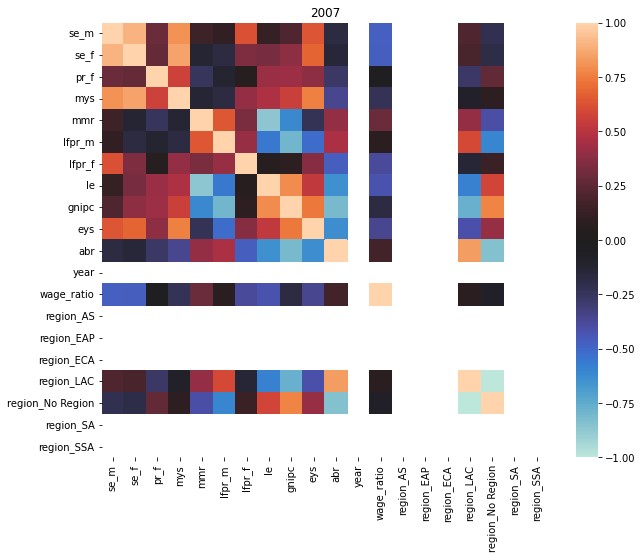

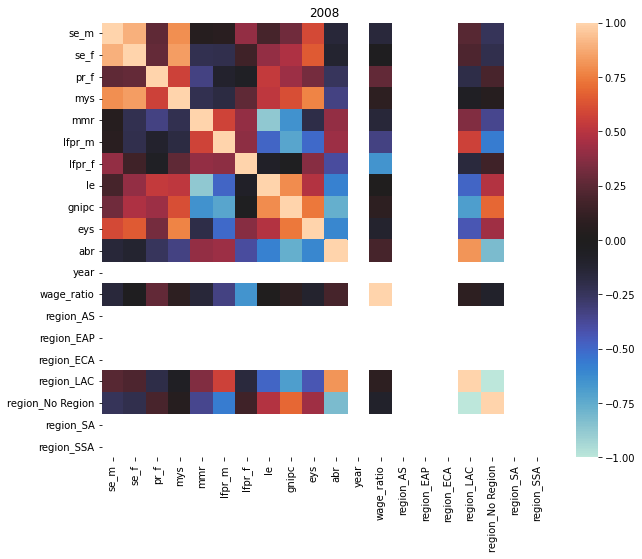

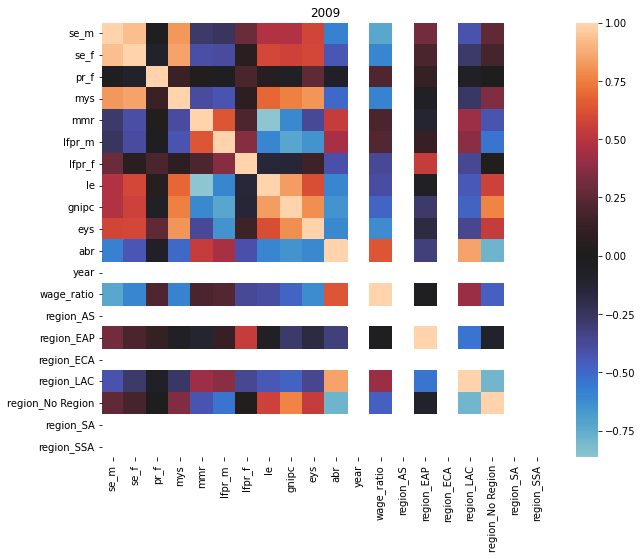

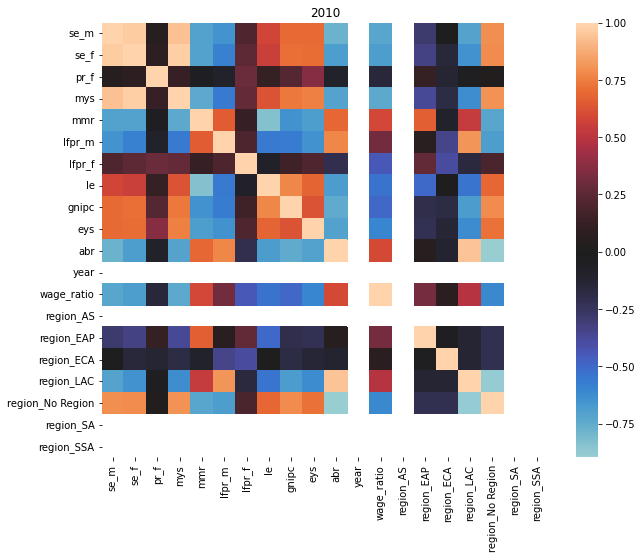

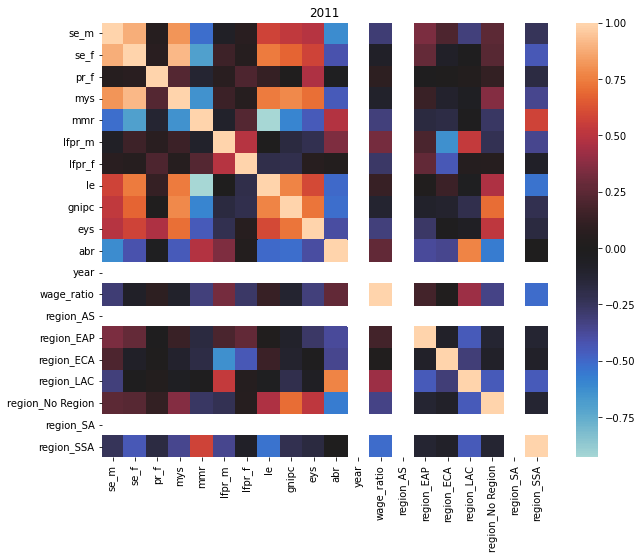

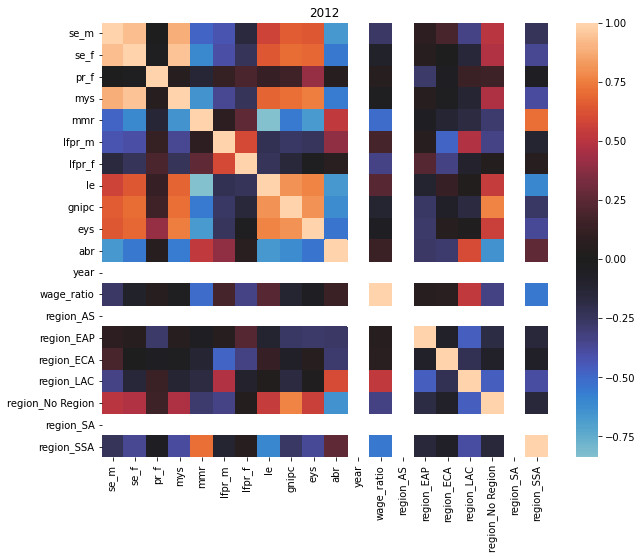

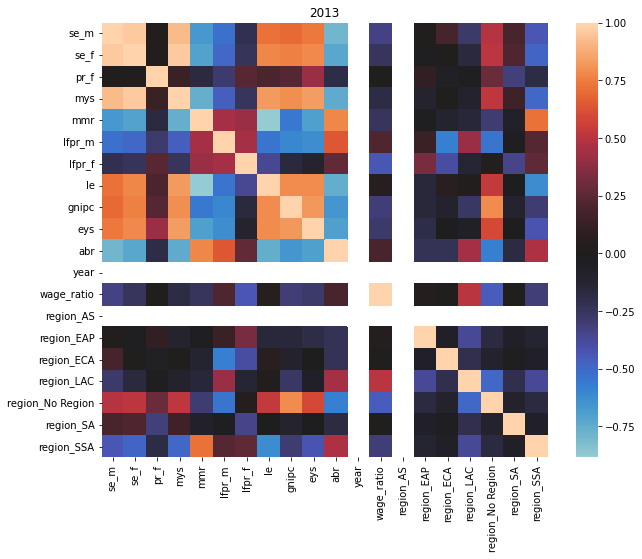

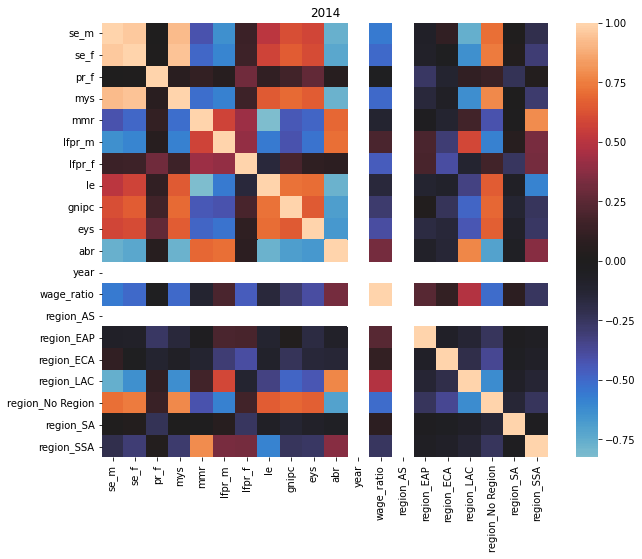

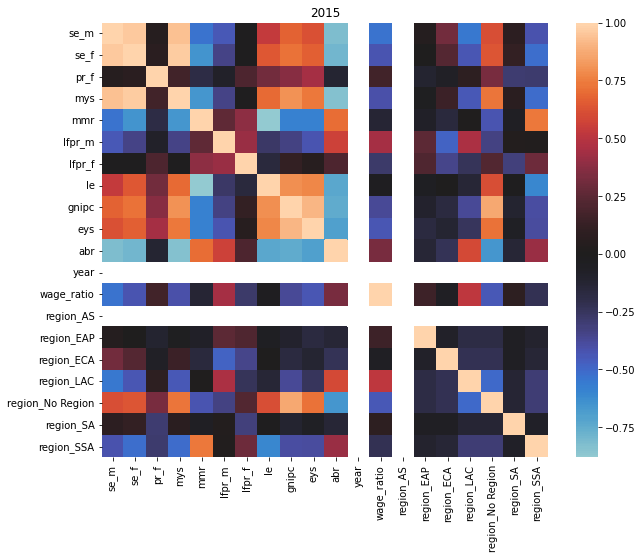

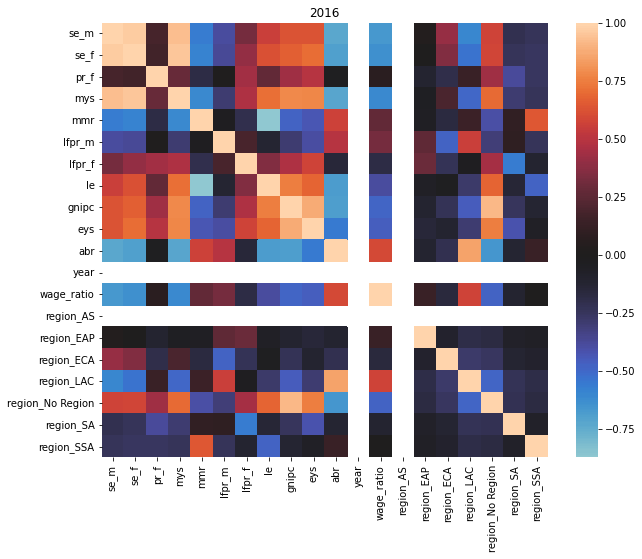

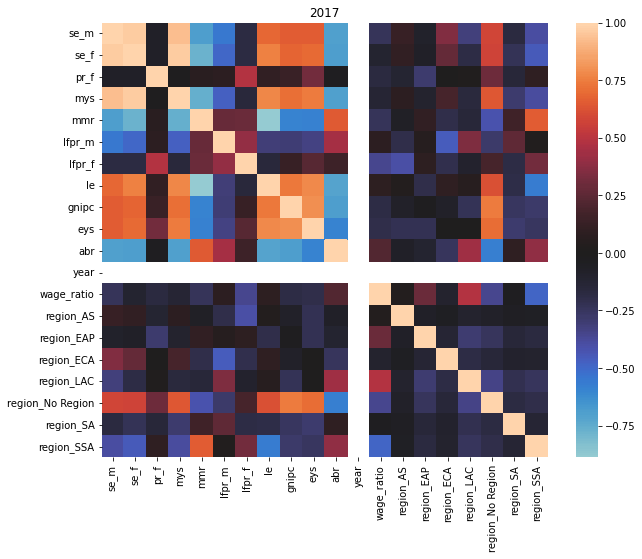

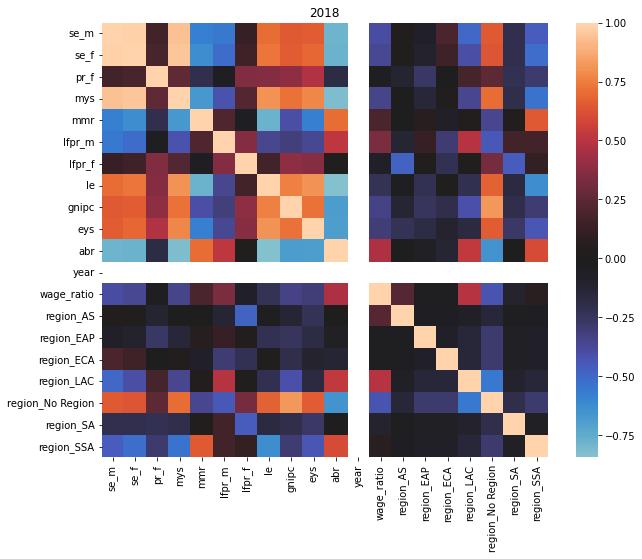

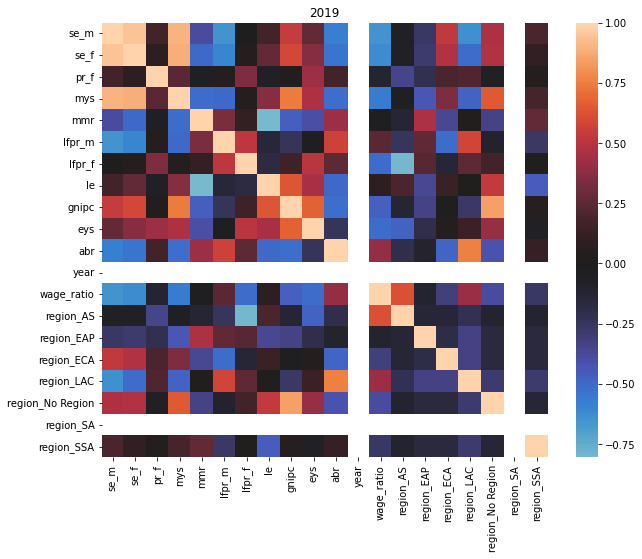

In [67]:
for year in np.sort(paygap_enc['year'].unique()):
  corr_matrix = paygap_enc.loc[paygap_enc['year']==year].corr()
  fig, ax = plt.subplots(figsize=(10,8)) 
  sns.heatmap(data = corr_matrix, center = 0)
  plt.title(str(year))

# Train/Test split example

In [68]:
# Note: This train/test is provided as a template, however each modeling method may require differnt types of train/test split.
# Please create a train/test split as part of the Modeling section that meets the needs of the speficic model


# Split the data into train/test sets based on year
#year = 2016
#paygap_train_time = paygap_enc.loc[paygap_enc['date'].dt.year <= year]
#paygap_test_time = paygap_enc.loc[paygap_enc['date'].dt.year > year]

#print(len(paygap_train_time))
#print(len(paygap_train_time)/len(paygap_enc))
#print(len(paygap_test_time))

# Principal Component Analysis (PCA)
## By implementing the Factorial Analysis of Mixed Data (FAMD)

FAMD generalizes PCA for datasets containing both numerical and categorical values.

For more information, please see [here](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210), and an example of the application of FAMD [here](https://medium.com/fifty-five-data-science/how-to-delete-bias-in-your-dataset-before-applying-a-clustering-ff1dfd14d179).

Steps of FAMD:

1. Standardize numerical columns by obtaining the z-score
2. Divide one-hot encoded categorical columns by the square root of its probability
3. Center the columns
4. Apply PCA on the new table

More resources:
[Plot for explained variance](https://vitalflux.com/pca-explained-variance-concept-python-example/), [2D projection of PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60), [Centering data for categorical variables](https://www.statology.org/center-data-in-python/)

Have not implemented yet:
[Visualize all the original dimensions](https://plotly.com/python/pca-visualization/), [PCA for time-series](https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data)

In [69]:
from scipy import stats

In [70]:
# # feature extraction with Principal Component Analysis (PCA)
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# # split data into training and testing set
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(paygap.select_dtypes('float'),test_size = 0.2, random_state = 0)

In [71]:
# print(pca.components_)

In [72]:
# print(pca.explained_variance_)

In [73]:
# print(pca.explained_variance_ratio_)

In [74]:
# numerical variables
X_n = pd.DataFrame(paygap.select_dtypes('float64'))
target = X_n['wage_ratio']
X_n = X_n.drop(columns=['wage_ratio'])
X_n.sample(10)
# standard scale the numerical variables
X_n_nor = stats.zscore(X_n)
X_n_nor.sample(10)

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr
213,1.560480,1.679132,1.475154,1.801530,-0.673301,0.936011,2.174707,1.465279,2.235776,2.014415,-1.283933
271,-1.035533,-1.062756,-0.756372,-0.662899,0.343630,1.090929,0.200925,-0.529680,-0.628360,-0.811396,0.723202
441,0.298691,0.366160,-1.995337,0.022605,-0.428846,-0.198589,0.546624,0.012076,2.913501,0.289607,-1.106162
207,-1.982289,-1.702436,-1.141271,-1.683220,0.099176,1.499680,-0.773731,-1.069469,-1.015385,-1.950629,1.986865
349,-0.724425,-0.413692,-1.097164,-0.410287,0.177401,0.734681,-0.706115,-0.133555,-0.367585,-0.753036,1.210007
353,1.196405,1.294800,1.972359,1.364737,-0.673301,-0.829542,0.994052,1.399367,2.077453,1.803528,-1.321437
20,-0.188273,0.108902,-0.630365,-0.369192,-0.125722,-0.192107,0.188742,0.074035,-0.345312,0.628962,0.070688
196,1.459026,1.501979,0.168297,0.946409,-0.614631,-1.534259,-0.171779,0.034465,0.131459,0.011178,-0.335992
117,-0.255790,0.057876,-0.983110,0.104029,-0.360399,0.726514,-0.185079,-0.189462,-0.837225,-0.417911,0.603115
118,1.509916,1.598288,-1.021745,1.054545,-0.438624,-0.929623,-0.215334,-0.052130,-0.506961,-0.492143,-0.751878


In [75]:
# categorical variables
X_c = pd.DataFrame(paygap.select_dtypes('object'))
X_c.sample(10)
# one-hot encode columns
X_c_nor = pd.get_dummies(X_c)
X_c_nor.sample(10)

,region_AS,region_EAP,region_ECA,region_LAC,region_No Region,region_SA,region_SSA,country_Albania,country_Argentina,country_Armenia,...,country_Tonga,country_Turkey,country_Uganda,country_Ukraine,country_United Kingdom,country_Uruguay,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Zambia,country_Zimbabwe
15,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
103,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [76]:
# probability for each one-hot encoded column
# 129 columns in total
# derive probability for each column
import math
probability = [] #square root of probability
for (columnname, columnData) in X_c_nor.iteritems():
  # print(columnData.values)
  p = math.sqrt(sum(columnData.values)/len(columnData.values))
  probability.append(p) 
print(probability)
print(len(probability))
# transform X_c_nor
test = X_c_nor / probability
print(test)
# center the columns
#create function to center data
center_function = lambda x: x - x.mean()
#apply function to original NumPy array
data_centered = center_function(test)

[0.09090909090909091, 0.26111648393354675, 0.24052284646041733, 0.7158188976374373, 0.5162643950727521, 0.1574591643244434, 0.2489647988659846, 0.045454545454545456, 0.18181818181818182, 0.11134044285378082, 0.0787295821622217, 0.045454545454545456, 0.045454545454545456, 0.10163945352271772, 0.0787295821622217, 0.18741389207353001, 0.14373989364401724, 0.045454545454545456, 0.19284730395996752, 0.0642824346533225, 0.0642824346533225, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.128564869306645, 0.10163945352271772, 0.17604469755488258, 0.045454545454545456, 0.0787295821622217, 0.12026142323020866, 0.0642824346533225, 0.17604469755488258, 0.18741389207353001, 0.19813177016093972, 0.0787295821622217, 0.045454545454545456, 0.10163945352271772, 0.0787295821622217, 0.045454545454545456, 0.0642824346533225, 0.045454545454545456, 0.0787295821622217, 0.16388869433927225, 0.045454545454545456, 0.045454545454545456, 0.19284730395

In [77]:
# # scale the dataset
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X = pd.concat([X_n,test],axis=1)
# sc.fit(X)
# X_nor = sc.transform(X)
# print(X_nor)
# X = X_nor

In [78]:
X=pd.concat([X_n_nor,data_centered],axis=1)
X=pd.concat([X_n_nor,X_c_nor],axis=1)
X.sample(10)

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,...,country_Tonga,country_Turkey,country_Uganda,country_Ukraine,country_United Kingdom,country_Uruguay,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Zambia,country_Zimbabwe
287,-2.120517,-2.149534,-1.065741,-2.851685,5.770522,0.965179,0.960244,-3.252046,-1.147655,-2.785481,...,0,0,0,0,0,0,0,0,0,0
123,0.308723,0.502145,0.220619,0.009203,0.216514,0.289501,-0.196856,-0.309407,-0.235782,0.022098,...,0,0,0,0,0,0,0,0,0,0
263,-1.308754,-1.387260,-0.726850,-1.244528,0.245849,1.223550,-1.129177,-0.442092,-0.750690,-1.419661,...,0,0,0,0,0,0,0,0,0,0
332,-0.716055,-1.011568,0.511452,-1.471645,1.096550,0.661565,2.540203,-1.363936,-0.825790,-1.304023,...,0,0,0,0,0,0,0,0,0,0
418,-0.244839,-0.504089,0.748651,-0.293119,1.164998,0.758146,0.688660,-1.500668,-0.843130,0.089208,...,0,0,0,0,0,0,0,0,0,0
25,1.036849,0.979079,1.865584,1.182171,-0.663522,-1.926935,-0.293713,1.157004,1.982303,2.293073,...,0,0,0,0,0,0,0,0,0,0
76,0.029800,-0.228088,2.724322,0.099075,0.861874,0.526222,0.616576,-1.327720,-0.748895,0.133994,...,0,0,0,0,0,0,0,0,0,0
315,-1.624973,-1.833799,0.034361,-1.922211,3.159747,1.217586,2.210851,-2.807620,-1.182917,-1.164301,...,0,0,0,0,0,0,0,0,0,0
391,1.479650,1.567032,0.891926,1.958539,-0.653744,-0.998591,0.217474,1.006483,1.821329,0.990172,...,0,0,0,0,0,0,0,0,0,0
475,-0.704426,-0.802092,0.932890,-0.827983,-0.262617,0.166993,-0.626416,-0.450316,-0.753581,-0.668435,...,0,0,0,0,0,0,0,0,0,0


[5.36503247e-01 1.19619315e-01 7.88878874e-02 6.20317799e-02
 3.84362235e-02 2.87729041e-02 2.50317632e-02 1.32615166e-02
 8.61743320e-03 6.36728361e-03 5.48890279e-03 4.74192367e-03
 4.64583797e-03 3.35058068e-03 3.31620842e-03 3.06144472e-03
 2.81439677e-03 2.60146266e-03 2.58289850e-03 2.32593145e-03
 2.27316937e-03 2.13976699e-03 1.91438632e-03 1.84119809e-03
 1.70619315e-03 1.56787180e-03 1.39391914e-03 1.29133448e-03
 1.28878963e-03 1.21573005e-03 1.15085226e-03 1.11389495e-03
 1.07430223e-03 1.00091163e-03 9.78491658e-04 9.51449362e-04
 9.04356893e-04 8.89315164e-04 8.28919083e-04 8.14451007e-04
 8.01609293e-04 7.68561326e-04 6.97848297e-04 6.72641959e-04
 6.50016407e-04 6.05418526e-04 5.83532026e-04 5.66159591e-04
 5.35221817e-04 5.12503403e-04 4.98946431e-04 4.92077841e-04
 4.90659559e-04 4.90588308e-04 4.88609547e-04 4.79572711e-04
 4.77481636e-04 4.58249845e-04 4.55462822e-04 4.16773278e-04
 4.08577440e-04 3.85537135e-04 3.71703299e-04 3.61366462e-04
 3.54145553e-04 3.348492

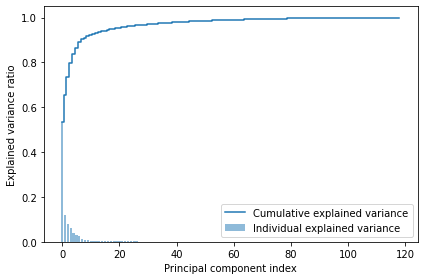

In [79]:
# Apply PCA algorithm
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(explained_variance)
# Create the visualization plot
plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [80]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
principalDf = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
print(principalDf)

[0.53650325 0.11961931]
     principal component 1  principal component 2
0                -1.148648              -0.280787
1                 0.464469              -0.413949
2                -3.949292               0.476938
3                -0.980485               0.697671
4                -1.069713              -0.431223
..                     ...                    ...
479              -1.594228               0.711320
480               2.584350              -0.638979
481               0.515635               0.094432
482               0.595222               2.671508
483              -0.718188              -2.973767

[484 rows x 2 columns]


In [81]:
target = target.reset_index(drop = True)
finalDf = pd.concat([principalDf, target], axis = 1)

<Figure size 144x432 with 0 Axes>

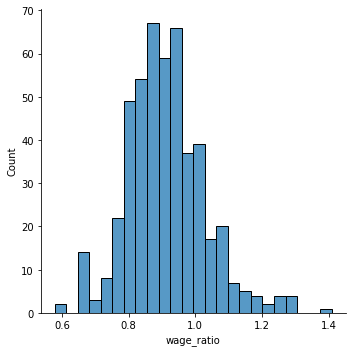

In [82]:
# check target range
fig = plt.figure(figsize = (2,6))
sns.displot(target)

Try binning wage_ratio to get 3 categories.

In [83]:
max_wr = max(target)
min_wr = min(target)
low_wr = np.percentile(target, 33)
med_wr = np.percentile(target, 66)
print('max:', max(target))
print('min:', min(target))
print('low:', np.percentile(target, 33))
print('med:', np.percentile(target, 66))
# group wage_ratio into 3 categories
target_gr_low = target[(target>=min_wr) & (target<low_wr)].index.tolist()
print(target_gr_low)
target_gr_med = target[(target>=low_wr) & (target<med_wr)].index.tolist()
print(target_gr_med)
target_gr_high = target[(target>=med_wr) & (target<=max_wr)].index.tolist()
print(target_gr_high)

max: 1.4096690360222364
min: 0.5784313725490196
low: 0.8571428571428571
med: 0.9459120175810618
[2, 14, 18, 21, 26, 29, 31, 32, 33, 38, 39, 40, 43, 46, 47, 49, 50, 54, 60, 61, 63, 68, 69, 79, 82, 84, 87, 88, 94, 98, 99, 100, 103, 106, 107, 114, 115, 118, 124, 125, 126, 127, 130, 133, 135, 138, 143, 147, 152, 153, 154, 156, 162, 165, 167, 168, 171, 172, 174, 180, 181, 182, 184, 188, 190, 191, 192, 194, 195, 198, 203, 204, 205, 209, 212, 213, 223, 236, 238, 241, 242, 243, 252, 253, 254, 259, 260, 261, 262, 267, 269, 272, 276, 277, 281, 287, 288, 289, 301, 307, 308, 312, 314, 315, 316, 325, 330, 331, 341, 345, 347, 351, 356, 357, 360, 363, 366, 369, 370, 378, 380, 382, 383, 384, 389, 390, 391, 392, 395, 396, 399, 406, 409, 413, 415, 419, 422, 424, 428, 431, 433, 436, 439, 442, 445, 448, 450, 454, 455, 459, 463, 464, 465, 466, 467]
[1, 5, 6, 13, 20, 25, 27, 28, 34, 36, 42, 48, 51, 55, 57, 59, 62, 64, 65, 67, 71, 72, 75, 76, 77, 83, 93, 95, 101, 102, 104, 108, 109, 113, 120, 122, 128, 129, 

In [84]:
target_cat = pd.DataFrame(np.zeros((len(target),1)))
for i in target_gr_low:
  target_cat.loc[i] = 'low'
for i in target_gr_med:
  target_cat.loc[i] = 'med'
for i in target_gr_high:
  target_cat.loc[i] = 'high'
print(target_cat)

        0
0    high
1     med
2     low
3    high
4    high
..    ...
479  high
480   med
481  high
482  high
483  high

[484 rows x 1 columns]


In [85]:
target_cat = target_cat.reset_index(drop = True)
target_cat.columns = ['target']
finalDf = pd.concat([principalDf, target_cat], axis = 1)
print(finalDf)

     principal component 1  principal component 2 target
0                -1.148648              -0.280787   high
1                 0.464469              -0.413949    med
2                -3.949292               0.476938    low
3                -0.980485               0.697671   high
4                -1.069713              -0.431223   high
..                     ...                    ...    ...
479              -1.594228               0.711320   high
480               2.584350              -0.638979    med
481               0.515635               0.094432   high
482               0.595222               2.671508   high
483              -0.718188              -2.973767   high

[484 rows x 3 columns]


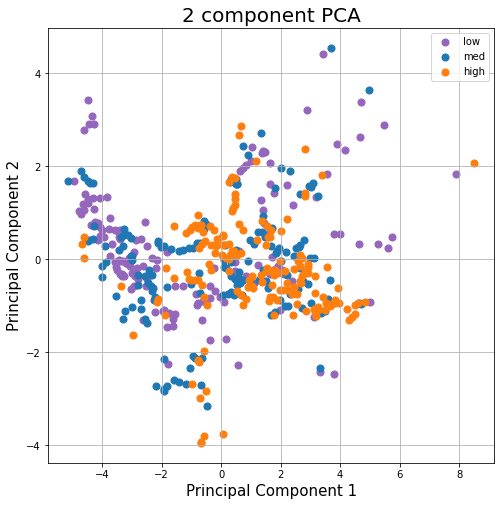

In [86]:
# Visualize 2D Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['low', 'med', 'high']
colors = ['tab:purple', 'tab:blue', 'tab:orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Models